# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())

### Load data

**Transcriptome** viral barcode frequencies:

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


Cell-gene matrix:

In [6]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [7]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

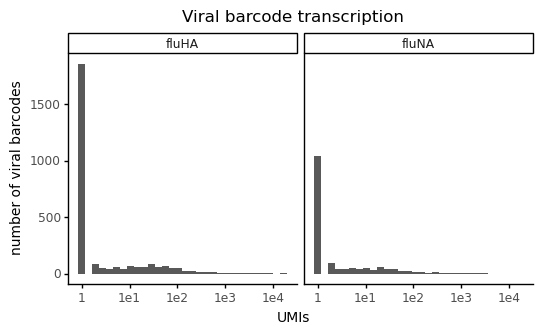

<ggplot: (8735302486447)>

In [8]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='UMIs',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

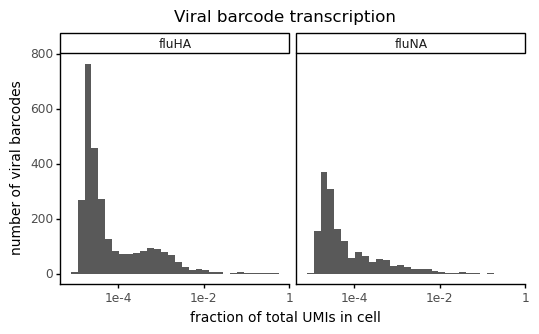

<ggplot: (8735302485023)>

In [9]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [10]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                   .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACCCAGTAACAAGT,20969,1,0,0,0,0,0,0,1,0
1,AAACCCATCATTGCTT,39505,2,1,0,0,1,0,0,0,0
2,AAACGAAAGATGTTGA,49137,10,0,0,0,0,0,0,6,4
3,AAACGAAGTACTTCCC,25547,11452,78,232,8,1,1780,192,6276,2885
4,AAACGAAGTAGACGTG,53719,2155,2,17,4,142,286,13,708,983
...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,27511,3,0,0,0,0,1,0,1,1
3364,TTTGATCTCGCATTGA,73596,4648,13,46,3,257,526,496,2251,1056
3365,TTTGGAGAGTTGCCTA,28413,2,0,0,0,0,1,0,1,0
3366,TTTGGAGGTATCGTTG,65134,1598,5,29,2,39,188,17,750,568


Bring in infection status and tag information:

In [12]:
viral_gene_expression = pd.merge(
    left=viral_gene_expression,
    right=(transcriptome_viral_bc_freqs
           .query('cell_barcode.notnull()',
                  engine='python')
           [['cell_barcode',
             'infected',
             'infecting_viral_tag']]
           .drop_duplicates()),
    on='cell_barcode',
    how='left',
    validate='one_to_one'
    )

viral_gene_expression

,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,20969,1,0,0,0,0,0,0,1,0,False,none
1,AAACCCATCATTGCTT,39505,2,1,0,0,1,0,0,0,0,False,none
2,AAACGAAAGATGTTGA,49137,10,0,0,0,0,0,0,6,4,False,none
3,AAACGAAGTACTTCCC,25547,11452,78,232,8,1,1780,192,6276,2885,True,both
4,AAACGAAGTAGACGTG,53719,2155,2,17,4,142,286,13,708,983,True,wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,TTTGATCTCCCGTTCA,27511,3,0,0,0,0,1,0,1,1,False,none
3364,TTTGATCTCGCATTGA,73596,4648,13,46,3,257,526,496,2251,1056,True,wt
3365,TTTGGAGAGTTGCCTA,28413,2,0,0,0,0,1,0,1,0,False,none
3366,TTTGGAGGTATCGTTG,65134,1598,5,29,2,39,188,17,750,568,True,wt


Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [13]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2
...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568


Check that total number of rows is = total number of cells * total number of genes, for both infected and uninfected:

In [14]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [15]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

Calculate the fraction of all UMIs assigned to each viral gene individually, and in aggregate:

In [16]:
viral_gene_expression_long['frac_viral_UMIs'] = (
    viral_gene_expression_long['viral_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037
...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720


Plot distribution of absolute UMI counts for each gene:

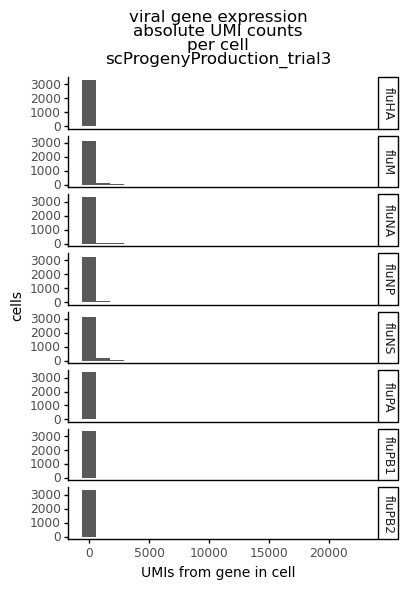

<ggplot: (8735302485038)>

In [17]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


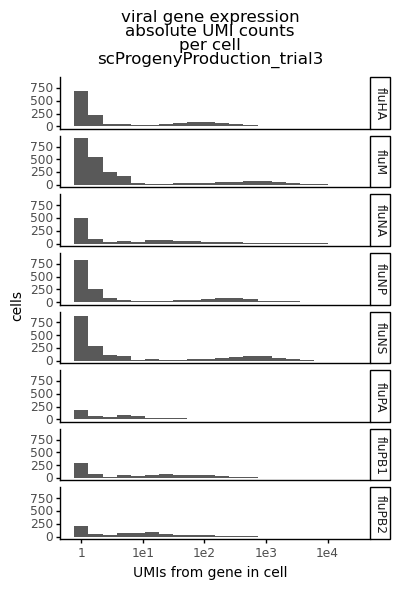

<ggplot: (8735303015768)>

In [18]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot distribution of fraction of UMIs from each viral gene:

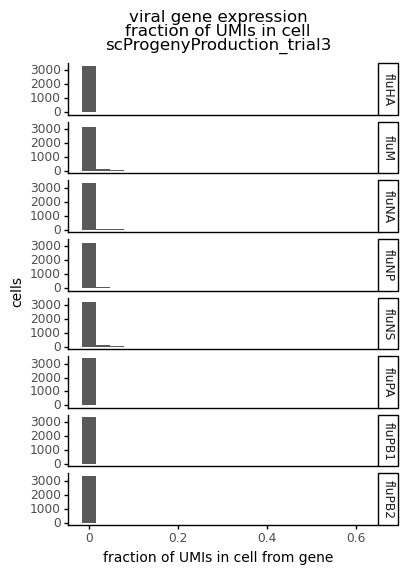

<ggplot: (8734637351087)>

In [19]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 16097 rows containing non-finite values.


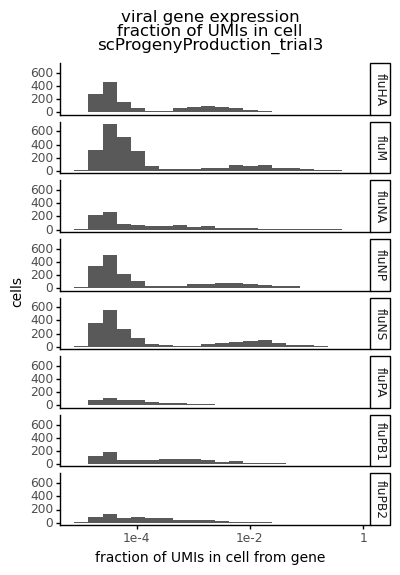

<ggplot: (8734637154509)>

In [20]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

What is the relationship between absolute UMI counts and fraction of all UMIs in cell for each gene?

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


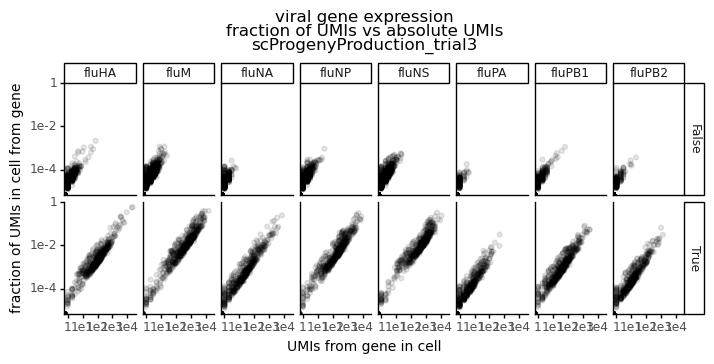

<ggplot: (8735302327598)>

In [21]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs',
                        y='frac_gene_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs vs absolute UMIs\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='fraction of UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

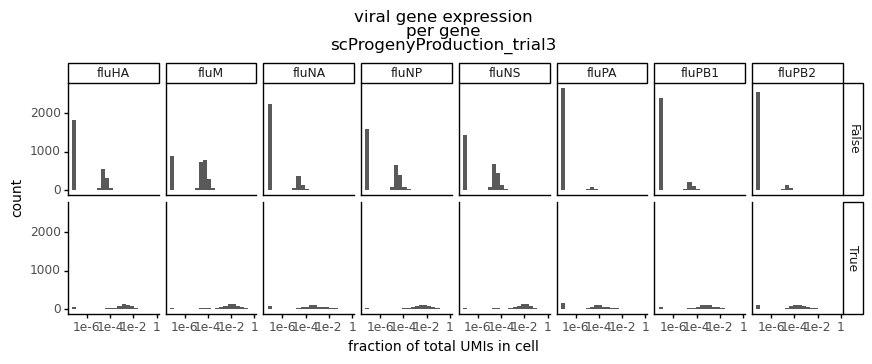

<ggplot: (8734637181061)>

In [22]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 16097 rows containing non-finite values.


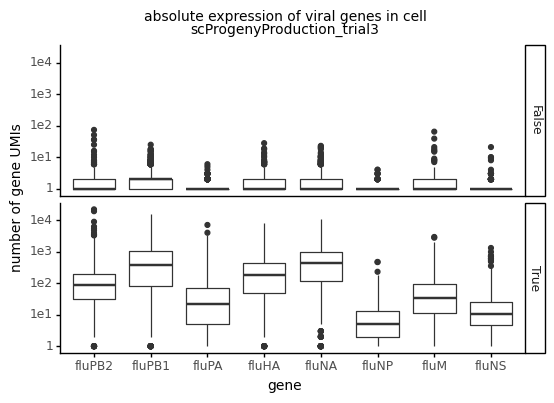

<ggplot: (8734637334194)>

In [23]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('absolute expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of gene UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete(labels=viral_genes))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 16097 rows containing non-finite values.


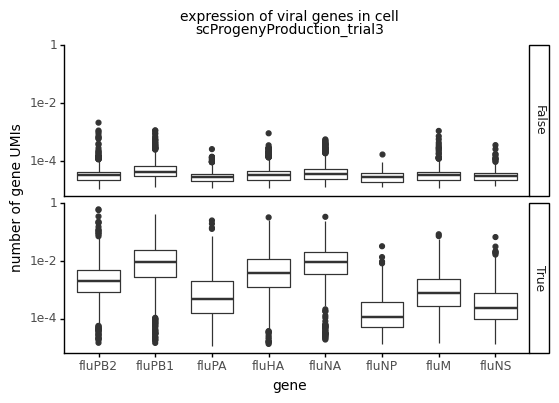

<ggplot: (8734634854394)>

In [24]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='frac_gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of gene UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete(labels=viral_genes))
display(fig)

#### Proportion of viral UMIs from each gene

Next, within each cell, I will calculate the proportion of all viral UMIs derived from each gene. 

In [25]:
viral_gene_expression_long['prop_viral_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['viral_UMIs']
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.000000
1,AAACCCATCATTGCTT,False,none,39505,2,fluPB2,1,0.000051,0.000025,0.500000
2,AAACGAAAGATGTTGA,False,none,49137,10,fluPB2,0,0.000204,0.000000,0.000000
3,AAACGAAGTACTTCCC,True,both,25547,11452,fluPB2,78,0.448272,0.003053,0.006811
4,AAACGAAGTAGACGTG,True,wt,53719,2155,fluPB2,2,0.040116,0.000037,0.000928
...,...,...,...,...,...,...,...,...,...,...
26939,TTTGATCTCCCGTTCA,False,none,27511,3,fluNS,1,0.000109,0.000036,0.333333
26940,TTTGATCTCGCATTGA,True,wt,73596,4648,fluNS,1056,0.063156,0.014349,0.227194
26941,TTTGGAGAGTTGCCTA,False,none,28413,2,fluNS,0,0.000070,0.000000,0.000000
26942,TTTGGAGGTATCGTTG,True,wt,65134,1598,fluNS,568,0.024534,0.008720,0.355444


Check that the proportion sums to 1 for every cell:

In [26]:
test_prop_sum_df = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_gene_expression_long
           .groupby('cell_barcode')
           ['prop_viral_UMIs']
           .sum()
           .round(4)),
    suffixes=[None,'_sum'],
    on='cell_barcode',
)

test_prop_sum_df['sum_OK'] = test_prop_sum_df.apply(
    lambda x: (x['prop_viral_UMIs_sum'] == 1) or (x['viral_UMIs'] == 0),
    axis=1)
                              
assert (test_prop_sum_df['sum_OK'] == True).all(), \
    "problem summing viral gene proportions"

test_prop_sum_df


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,prop_viral_UMIs_sum,sum_OK
0,AAACCCAGTAACAAGT,False,none,20969,1,fluPB2,0,0.000048,0.000000,0.00,1.0,True
1,AAACCCAGTAACAAGT,False,none,20969,1,fluPB1,0,0.000048,0.000000,0.00,1.0,True
2,AAACCCAGTAACAAGT,False,none,20969,1,fluPA,0,0.000048,0.000000,0.00,1.0,True
3,AAACCCAGTAACAAGT,False,none,20969,1,fluHA,0,0.000048,0.000000,0.00,1.0,True
4,AAACCCAGTAACAAGT,False,none,20969,1,fluNP,0,0.000048,0.000000,0.00,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26939,TTTGTTGAGTGCAGCA,False,none,58559,4,fluHA,1,0.000068,0.000017,0.25,1.0,True
26940,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNP,0,0.000068,0.000000,0.00,1.0,True
26941,TTTGTTGAGTGCAGCA,False,none,58559,4,fluNA,0,0.000068,0.000000,0.00,1.0,True
26942,TTTGTTGAGTGCAGCA,False,none,58559,4,fluM,1,0.000068,0.000017,0.25,1.0,True


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 1672 rows containing non-finite values.


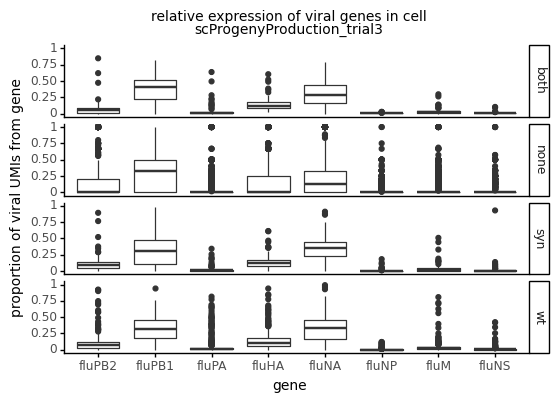

<ggplot: (8734634741315)>

In [27]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='prop_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('relative expression of viral genes in cell\n'
                         f'{expt}') +
              p9.facet_grid('infecting_viral_tag~') +
              p9.xlab('gene') +
              p9.ylab('proportion of viral UMIs from gene') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete(labels=viral_genes))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1672 rows containing missing values.


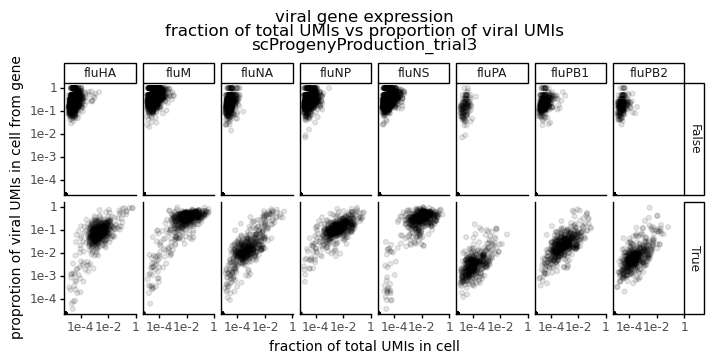

<ggplot: (8735302292818)>

In [28]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs',
                        y='prop_viral_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of total UMIs vs proportion of viral UMIs\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell',
               y='proprotion of viral UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)